In [1]:
### importing QComp ###
include("../src/QuantumPrimer.jl")
using .QuantumPrimer
using Yao
using Optim
using LinearAlgebra
using PyPlot

In [2]:
#Example target functions: simple polynomials (x^n) work well for both qsp and qsvt, others only for qsvt 
y1(x) = 4x^5-5x^3+x
y2(x) = x^2
y3(x) = x^3
y4(x) = 0.9*x^4+0.1*x^2
y5(x) = 0.5*(5x^3-3x)
y6(x) = 0.3*x^6-0.2*x^4+0.1*x^2
y7(x) = sign(x)
ys = [y1,y2,y3,y4,y5,y6,y7];

In [3]:
targ=ys[3] # choose target fn
d=3 # set based on degree of target function
phi0=ones(d+1) # set initial angles (can be random)
xs=collect(range(-1,1,50)); # training points

In [4]:
#using simple optimiser to find angles: literature contains other methods
r=optimize(phis -> loss(targ,xs,phis), phi0, NelderMead(), Optim.Options(store_trace = true)) 

 * Status: success

 * Candidate solution
    Final objective value:     6.885192e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    105
    f(x) calls:    190


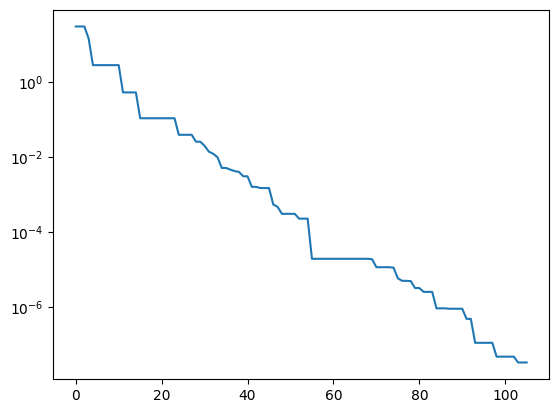

In [5]:
#Extract optimal angles
phi_opt = Optim.minimizer(r)

#Extract loss track
trace=Optim.trace(r)
trace_err = []
for i in 1:length(trace)
    append!(trace_err, parse(Float64, split(string(trace[i]))[2]))
end

PyPlot.semilogy(0:Optim.iterations(r),trace_err)
PyPlot.display_figs()

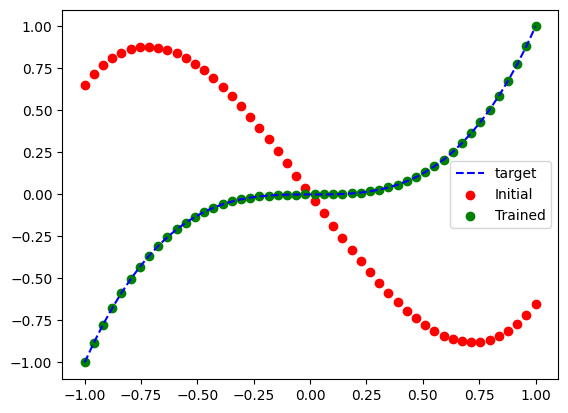

In [6]:
#Plot target vs QSP function
PyPlot.plot(xs,targ.(xs),"b--",label="target")
PyPlot.scatter(xs,map(j->eval_Usp(xs[j],phi0),1:length(xs)),color="r",label="Initial")
PyPlot.scatter(xs,map(j->eval_Usp(xs[j],phi_opt),1:length(xs)),color="g",label="Trained")
PyPlot.legend()
PyPlot.display_figs()

## QSVT example

In [7]:
A = [[0.1 0.2]; [0.3 0.4]]; #note: not a Hermitian matrix
N=size(A)[1] # number of singular values
n=Int(log2(size(A)[1])) # number of qubits
Matrix(block_encode2(n,A)) #test block encoding

4×4 Matrix{ComplexF64}:
 0.1+0.0im  0.2+0.0im  0.0+0.0im  0.0+0.0im
 0.3+0.0im  0.4+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  1.0+0.0im

In [8]:
Uphi = QSVT_square(n,d,phi_opt,A); #QSVT circuit using same phis from qsp

In [9]:
Matrix(Uphi) #matrix transformed in top right corner

4×4 Matrix{ComplexF64}:
 0.0379987-0.000312977im  0.0539982-0.000444757im  …       0.0+0.0im
 0.0859971-0.000708316im   0.121996-0.00100482im           0.0+0.0im
       0.0+0.0im                0.0+0.0im                  0.0+0.0im
       0.0+0.0im                0.0+0.0im             0.999966+0.00823623im

In [10]:
#to project directly onto transformed matrix
prj1 = kron(state(zero_state(1)),Matrix(chain(n,repeat(I2,n))));
M_prj = real(prj1'*Matrix(Uphi)*prj1)

2×2 Matrix{Float64}:
 0.0379987  0.0539982
 0.0859971  0.121996

In [11]:
#transform singular values directly: check if QSVT has worked
decomp=svd(A);
u1 = decomp.U;
sv = decomp.S;
v1 = decomp.V;
if d%2 == 0 #even functions
    A_new = sum(targ(sv[i])*u1[:,i]*u1[:,i]' for i=1:N) # = targ(A) if A is hermitian
else #odd functions
    A_new = sum(targ(sv[i])*u1[:,i]*v1[:,i]' for i=1:N) # = targ(A) if A is hermitian
end

2×2 Matrix{Float64}:
 0.038  0.054
 0.086  0.122